In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, h5py
import matplotlib.pyplot as plt
import numpy as np, healpy as hp
from scipy import stats, special, linalg, optimize
import emcee, tqdm, corner

In [3]:
def downsize(arr, nbig, nsmall):
    return np.sum(np.reshape(arr, (-1,int((nbig/nsmall)**2+0.1))), axis=1)

In [4]:
from GenerateSphHarm_decomposed import sphharm_sum_quick, sphharm_sum_truth, real_harmonics

# Fit to true data

In [10]:
lmax=20
nlm = int(lmax*(lmax+1)/2+0.01)

In [11]:
import h5py
nside=64

In [12]:
data = {}
mag = 20.
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    data['n'] = hf[str(magid)]['n'][...]
    data['k'] = hf[str(magid)]['k'][...]
    data['hpx'] = hf[str(magid)]['hpx'][...]

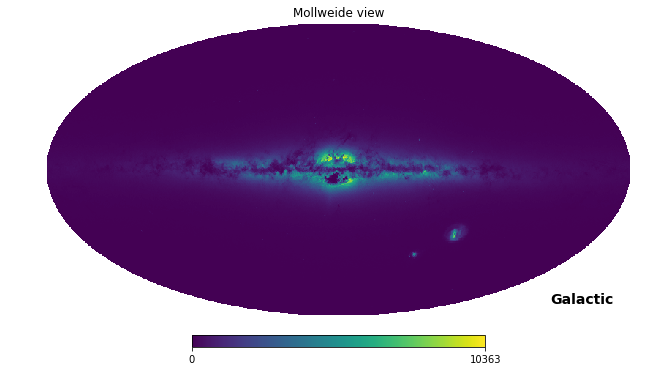

In [13]:
hp.mollview(data['k'], nest=True, coord=['C','G'])

In [16]:
# generate sph harm grid
Ylm_grid = np.zeros((2*nlm, hp.nside2npix(nside)))
ring2nest = hp.nest2ring(nside, np.arange(hp.nside2npix(nside)))
for ii in tqdm.tqdm_notebook(range(nlm)):
    alm_grid = np.zeros(nlm)
    alm_grid[ii]=1
    Ylm_grid[ii] = hp.sphtfunc.alm2map(alm_grid+0.j*alm_grid,nside=nside,verbose=False)[ring2nest]
    Ylm_grid[nlm+ii] = hp.sphtfunc.alm2map(0.*alm_grid+1.j*alm_grid,nside=nside,verbose=False)[ring2nest]

In [17]:
Ylm_grid=Ylm_grid.T

In [23]:
def nloglike_grad(params, k, n, hpx, nlm):
    x = np.sum(params*Ylm_grid.T, axis=1)[hpx]
    
    exp_x = np.exp(x)
    log1p_exp_x = np.log1p(exp_x)
    
    logl = np.sum( k*x - n*log1p_exp_x )
    
    grad_norm = k - n*exp_x/(1+exp_x)
    grad = np.sum(grad_norm[:,None] * Ylm_grid[hpx], axis=0)
    
    return -logl, -grad

In [21]:
p0=np.random.normal(0.,1., size=Ylm.shape[0])

In [299]:
%timeit nloglike_grad(p0, data['k'],data['n'],data['hpx'],nlm)

956 ms ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [317]:
%timeit x = np.sum(p0*Ylm_grid, axis=1)#[data['hpx']]

67.3 ms ± 808 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [294]:
%timeit np.log1p(np.exp(x))

6.16 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [295]:
%timeit np.log(1+np.exp(x))

7.65 ms ± 95.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [305]:
%timeit np.sum(Ylm_grid, axis=0)

66.5 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
p0=np.random.normal(0.,1., size=2*nlm)
result = scipy.optimize.minimize(nloglike_grad, p0, method='Newton-CG', 
                                 args=(data['k'],data['n'],data['hpx'],nlm), jac=True)
result

     fun: 14457893.48232667
     jac: array([ 0.00397894, -0.67473971,  0.37921709,  0.29462934,  0.238036  ,
       -0.71200081,  0.4873868 ,  0.83265565, -1.54855441,  0.4752865 ,
        0.54581736, -0.01281961, -0.40751502, -0.23317855,  0.51991686,
       -0.1464338 ,  0.36932255, -0.94996062,  0.48832994,  0.15539765,
        0.56878157, -0.77408656,  0.68569182, -0.41930866,  0.5436072 ,
       -0.2788061 , -0.18661261, -0.05551167,  0.2568522 , -0.02851763,
       -1.41807669,  1.09622345, -0.71760845,  0.31599898, -0.19816087,
       -0.45497013,  1.30471192, -1.10138741,  0.69209664, -1.34045525,
        0.7775244 ,  0.05645022, -0.68194331,  0.60114962, -0.49234669,
        0.24661101, -0.97039533,  1.70765613, -1.30238851, -0.25713977,
        1.13060666, -0.93522728,  1.05594679, -0.58391829, -0.10446615,
        0.21870224,  0.60549888,  0.80629839,  0.71701281, -0.95985013,
       -0.2861175 , -0.31126592, -0.17683658,  0.58941203, -0.49820109,
        0.25945825,  0.142

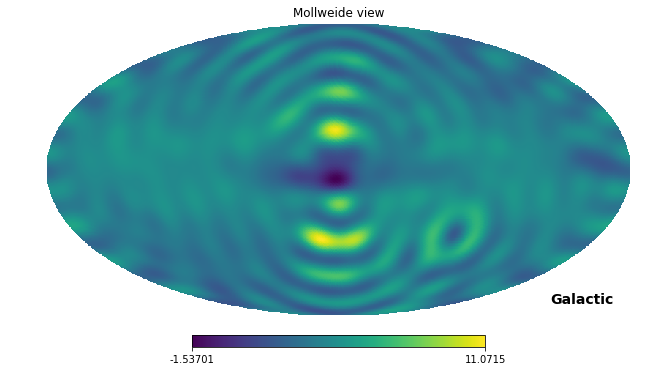

In [34]:
x = hp.sphtfunc.alm2map(result['x'][:nlm]+1.j*result['x'][nlm:],nside=nside,verbose=False)
hp.mollview(x, coord=['C','G'])

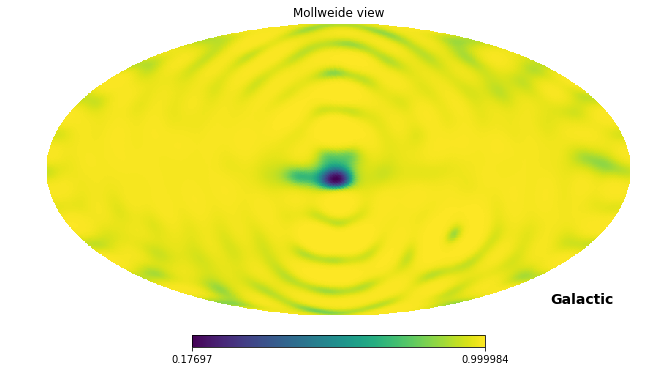

In [37]:
hp.mollview(expit(x), coord=['C','G'])

In [281]:
p0=np.random.normal(0.,1., size=2*nlm)
result = scipy.optimize.minimize(nloglike_grad, p0, method='Newton-CG', 
                                 args=(data['k'],data['n'],data['hpx'],nlm), jac=True)
result

     fun: 796544.9008366253
     jac: array([-0.02314287,  0.01065522,  0.01349295, -0.01842746,  0.04937866,
       -0.03270201,  0.00429707,  0.02316283, -0.04259027,  0.00212463,
       -0.00831156,  0.04112825, -0.03733593,  0.00782711,  0.00037221,
        0.00572685,  0.01445518, -0.04441173,  0.0634857 , -0.04913839,
       -0.02287013, -0.02808538, -0.01095962, -0.01943482, -0.00476187,
       -0.01324316,  0.04095274, -0.02551156,  0.01635008, -0.02966488,
        0.0038684 ,  0.02019909, -0.01214724,  0.04888774, -0.02445988,
        0.02259318, -0.03762789,  0.00406144,  0.01252773,  0.00716579,
        0.03125345, -0.02961243,  0.02170751, -0.02106722,  0.07324775,
       -0.02741093, -0.00243777, -0.00099981,  0.04807291, -0.05803136,
        0.01139847, -0.00669924,  0.03017896,  0.00183561, -0.04682262,
        0.0568872 , -0.05219506,  0.02286904, -0.01514619,  0.00610802,
        0.02494765, -0.01101356, -0.01973909,  0.01006653, -0.04592523,
        0.04350943, -0.033

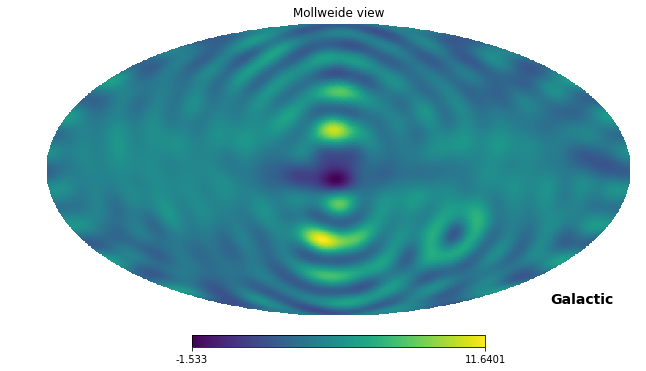

In [283]:
x = hp.sphtfunc.alm2map(result['x'][:nlm]+1.j*result['x'][nlm:],nside=nside,verbose=False)
hp.mollview(x, coord=['C','G'])

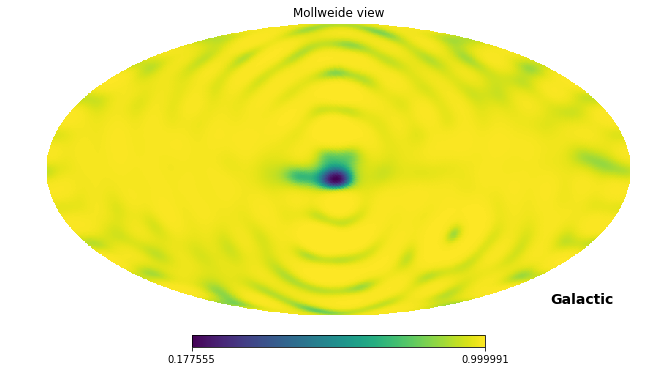

In [284]:
hp.mollview(expit(x), coord=['C','G'])

# Speed boosted code

In [5]:
from numba import njit
import h5py

In [6]:
@njit
def sphharm_slow(alm, Ylm, n, k, npix, nmode, grad):
    """
    alm - ndarray - (Nmode)
    _lambda - ndarray - (Nmode, Nring)
    azimuth - ndarray - (2*lmax+1, Npix)
    mmode - ndarray - (Nmode)
    lmax - int
    jpix - ndarray - (Npix)
    Nring - int
    """
    grad *= 0.
    loglike = 0.

    for i in range(npix):
        x=0.
        for nu in range(nmode):
            x += Ylm[nu,i]*alm[nu]
        loglike += k[i]*x - n[i]*np.log(1+np.exp(x))
            
        for nu in range(nmode):
            grad[nu] += (k[i] - n[i]*(np.exp(x)/(1+np.exp(x))))*Ylm[nu,i]
        
    return loglike, grad

@njit
def nloglike_decomposed(alm, n, k, _lambda, azimuth, m, lmax, jpix, Nring, F):
    """
    alm - ndarray - (Nmode)
    _lambda - ndarray - (Nmode, Nring)
    azimuth - ndarray - (2*lmax+1, Npix)
    mmode - ndarray - (Nmode)
    lmax - int
    jpix - ndarray - (Npix)
    Nring - int
    """
    F *= 0.
    grad *= 0.
    loglike = 0.
    
    nu = 0
    for _m in m:
        for j in range(Nring):
            F[_m+lmax, j] += _lambda[nu,j]*alm[nu]
        nu += 1
    
    i = 0; nu = 0
    for j in jpix:
        x=0.
        for _m in range(-lmax, lmax+1):
            x += F[_m+lmax, j]*azimuth[_m+lmax, i]
        loglike += k[i]*x - n[i]*np.log(1+np.exp(x))
        i += 1
        
    return -loglike, -grad

@njit
def nloglike_grad_decomposed(alm, n, k, _lambda, azimuth, m, lmax, jpix, Nring, F, grad):
    """
    alm - ndarray - (Nmode)
    _lambda - ndarray - (Nmode, Nring)
    azimuth - ndarray - (2*lmax+1, Npix)
    mmode - ndarray - (Nmode)
    lmax - int
    jpix - ndarray - (Npix)
    Nring - int
    """
    F *= 0.
    grad *= 0.
    loglike = 0.
    
    nu = 0
    for _m in m:
        for j in range(Nring):
            F[_m+lmax, j] += _lambda[nu,j]*alm[nu]
        nu += 1
    
    i = 0; nu = 0
    for j in jpix:
        x=0.
        for _m in range(-lmax, lmax+1):
            x += F[_m+lmax, j]*azimuth[_m+lmax, i]
        loglike += k[i]*x - n[i]*np.log(1+np.exp(x))
        
        nu = 0
        for _m in m:
            Y = _lambda[nu,j]*azimuth[_m+lmax,i]
            grad[nu] += (k[i] - n[i]*(np.exp(x)/(1+np.exp(x))))*Y
            nu+=1
        i += 1
        
    return -loglike, -grad

def nloglike_grad(params, k, n, nlm):
    x = np.sum(params*Ylm_grid.T, axis=1)
    
    logl = np.sum( k*x - n*np.log(1+np.exp(x)) )
    
    grad_norm = k - n*np.exp(x)/(1+np.exp(x))
    grad = np.sum(grad_norm * Ylm_grid, axis=1)
    
    return -logl, -grad

In [7]:
nside=32; lmax=20
nlm = int(lmax*(lmax+1)/2+0.01)

In [8]:
_harmonics = {}
with h5py.File('/data/asfe2/Projects/gaia_edr3/sphericalharmonics_decomposed_nside{0}_lmax{1}.h5'.format(nside,lmax), 'r') as hf:
    for key in hf.keys():
        _harmonics[key] = hf[key][...]
        
Ylm_grid = real_harmonics(_harmonics['lambda'], _harmonics['azimuth'], _harmonics['m'], lmax, _harmonics['jpix'],)

In [9]:
data = {}
mag = 20.
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    data['n'] = np.zeros(hp.nside2npix(128))
    data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
    data['n'] = downsize(data['n'], 128, nside)
    data['k'] = np.zeros(hp.nside2npix(128))
    data['k'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k'][...]
    data['k'] = downsize(data['k'], 128, nside)

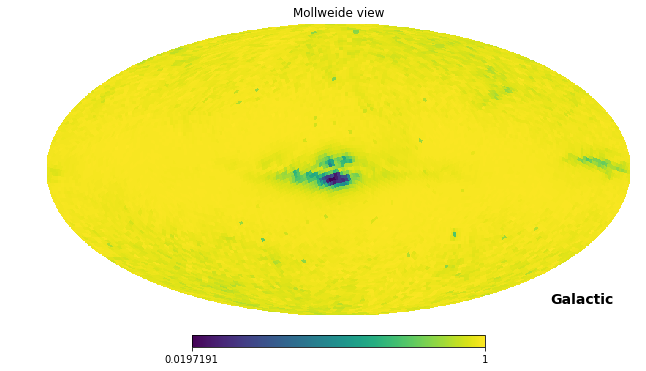

In [10]:
hp.mollview(data['k']/data['n'], nest=True, coord=['C','G'])

In [11]:
p0=np.random.normal(0.,1., size=_harmonics['m'].shape[0])

### Grad liklihood

In [52]:
%timeit nloglike_grad(p0, data['k'], data['n'], len(p0))

15.3 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
nloglike_grad(p0, data['k'], data['n'], len(p0))

(136857043.69332048,
 array([-5722280.06108961, -2205029.2635378 ,  3092778.04146017,
         -732844.08625076,  3673239.19401235,  3050780.29564998,
         -620397.1670973 ,  2136814.10824282,  -365736.67256452,
        -1490861.4167889 , -2133447.83130029,  -603415.47002831,
         -829479.73483339, -2469552.60461973,  -206966.50209057,
         1092030.90496996,  -634859.42801831,  -195534.42848796,
        -2735183.33680321,  -696949.68747698,  2533964.72789885,
         2055863.53471862,   116011.3355136 ,   102069.19181149,
         -428430.24767572,  1848972.74969628,   831480.03520867,
         1660478.07521878,  2617901.93810253,   686348.02177453,
        -2360201.19147164,   314704.3470624 ,   144072.13560158,
        -1600848.64166971,  2496092.24120904, -3274132.16859517,
         1679282.38347029,  -184782.92117568,   -63776.7151691 ,
        -2112591.03972582,  1332469.1063841 , -1728625.36525405,
          141691.37721593, -2424997.85269762,  1623257.01068881,
    

### Quick evaluation

In [13]:
Nring = _harmonics['lambda'].shape[1]
F = np.zeros((2*lmax+1, Nring))
grad = np.zeros((_harmonics['m'].shape[0]))

In [66]:
%timeit sphharm_quick(p0, data['n'], data['k'], _harmonics['lambda'], _harmonics['azimuth'], \
              _harmonics['m'], lmax, _harmonics['jpix'], Nring, F, grad)

40.9 ms ± 7.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
sphharm_quick(p0, data['n'], data['k'], _harmonics['lambda'], _harmonics['azimuth'], 
              _harmonics['m'], lmax, _harmonics['jpix'], Nring, F, grad)

(136857043.69332093,
 array([-5722280.06108962, -2205029.26353779,  3092778.04146017,
         -732844.08625076,  3673239.19401235,  3050780.29564997,
         -620397.1670973 ,  2136814.10824283,  -365736.67256452,
        -1490861.41678889, -2133447.83130029,  -603415.4700283 ,
         -829479.73483339, -2469552.60461973,  -206966.50209056,
         1092030.90496996,  -634859.42801832,  -195534.42848796,
        -2735183.33680322,  -696949.68747699,  2533964.72789885,
         2055863.53471862,   116011.3355136 ,   102069.19181149,
         -428430.24767573,  1848972.74969627,   831480.03520867,
         1660478.07521879,  2617901.93810251,   686348.02177453,
        -2360201.19147164,   314704.3470624 ,   144072.13560157,
        -1600848.64166971,  2496092.24120905, -3274132.16859518,
         1679282.38347029,  -184782.92117568,   -63776.7151691 ,
        -2112591.03972582,  1332469.1063841 , -1728625.36525405,
          141691.37721592, -2424997.85269762,  1623257.01068881,
    

In [ ]:
p0=np.random.normal(0.,1., size=_harmonics['m'].shape[0])
result = optimize.minimize(sphharm_quick, p0, method='Newton-CG', 
                    args=(data['n'], data['k'], _harmonics['lambda'], _harmonics['azimuth'], \
                              _harmonics['m'], lmax, _harmonics['jpix'], Nring, F, grad), jac=True)
result

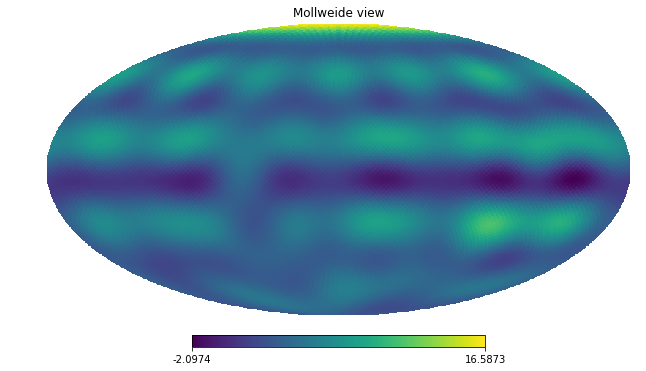

In [59]:
hp.mollview(np.sum(Ylm_grid.T * result['x'], axis=1))

In [38]:
grad = np.zeros(Ylm.shape[0])
%timeit sphharm_slow(p0, Ylm_grid, data['n'], data['k'], Ylm_grid.shape[1], Ylm_grid.shape[0], grad)

362 ms ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [127]:
p0=np.random.normal(0.,1., size=_harmonics['m'].shape[0])
result = scipy.optimize.minimize(sphharm_slow, p0, method='SLSQP', 
                                 options={'disp':True,'xtol':1e-8},
                    args=(Ylm, data['n'], data['k'], Ylm.shape[1], Ylm.shape[0], grad), jac=True)
#result

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:4: OptimizeWarning: Unknown solver options: xtol
  after removing the cwd from sys.path.


Iteration limit exceeded    (Exit mode 9)
            Current function value: nan
            Iterations: 101
            Function evaluations: 1101
            Gradient evaluations: 101


In [129]:
result['x']

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

/home/andy/py3/lib/python3.5/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/andy/py3/lib/python3.5/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/andy/py3/lib/python3.5/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


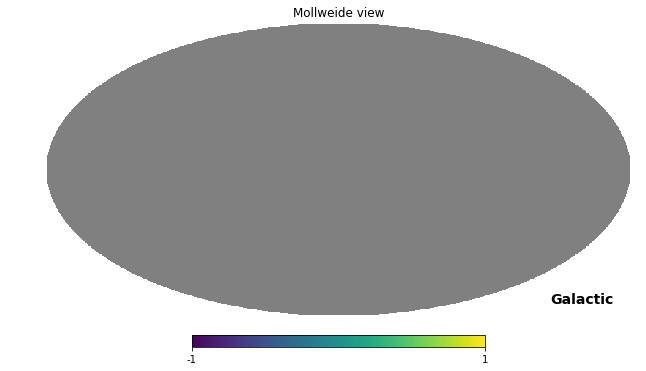

In [128]:
hp.mollview(np.sum(Ylm.T * result['x'], axis=1), coord=['C','G'])

### Test gradient

In [61]:
grad = np.zeros(Ylm.shape[0])
model = lambda x: sphharm_slow(x, Ylm, data['n'], data['k'], Ylm.shape[1], Ylm.shape[0], grad)[0]
gradient = lambda x: sphharm_slow(x, Ylm, data['n'], data['k'], Ylm.shape[1], Ylm.shape[0], grad)[1]

In [62]:
scipy.optimize.approx_fprime(p0, model, 1e-5)

array([ 4.16921431e+05,  4.39949649e+04,  2.18520445e+05,  3.52559865e+04,
       -2.47499787e+04,  6.13242822e+04, -2.45431471e+04,  5.49458058e+04,
       -4.49509529e+04,  3.29059361e+04,  2.13310907e+04,  1.74440270e+04,
       -1.66817049e+05,  3.74429556e+04, -4.05038986e+04, -7.65636927e+03,
        3.81819271e+04,  6.53818484e+04,  3.00017331e+04, -1.88727360e+04,
       -1.64044628e+05,  1.86762214e+02, -1.68990647e+04, -1.85821279e+04,
       -4.17378461e+04, -1.82072625e+04,  5.47102647e+04,  3.42691220e+04,
        3.80093736e+04, -4.94880693e+04, -6.14051715e+04, -3.16205440e+04,
        3.52013744e+03,  4.60375762e+03, -6.06525603e+04, -1.05440915e+04,
       -1.38591757e+04, -1.40294999e+04,  5.90616236e+04, -5.97751106e+04,
        5.24896484e+04, -2.00729986e+04,  8.91173030e+04, -2.59285321e+04,
        6.88131787e+03, -1.29159370e+04, -4.30862473e+04, -2.66474470e+04,
       -1.40647649e+04, -1.46929361e+02, -2.92142440e+04,  2.53759307e+04,
        1.57493169e+04, -

In [63]:
gradient(p0)

array([ 4.16921508e+05,  4.39950438e+04,  2.18520519e+05,  3.52560649e+04,
       -2.47499090e+04,  6.13243900e+04, -2.45430957e+04,  5.49459100e+04,
       -4.49508805e+04,  3.29060056e+04,  2.13311976e+04,  1.74440862e+04,
       -1.66816977e+05,  3.74430175e+04, -4.05038109e+04, -7.65630803e+03,
        3.81819872e+04,  6.53819665e+04,  3.00018189e+04, -1.88726834e+04,
       -1.64044561e+05,  1.86829876e+02, -1.68989828e+04, -1.85820215e+04,
       -4.17377799e+04, -1.82072033e+04,  5.47103733e+04,  3.42692010e+04,
        3.80094584e+04, -4.94880140e+04, -6.14051061e+04, -3.16204830e+04,
        3.52021284e+03,  4.60384929e+03, -6.06524658e+04, -1.05440364e+04,
       -1.38591252e+04, -1.40293936e+04,  5.90617171e+04, -5.97750277e+04,
        5.24897320e+04, -2.00729539e+04,  8.91173754e+04, -2.59284709e+04,
        6.88138828e+03, -1.29158609e+04, -4.30861511e+04, -2.66473655e+04,
       -1.40647068e+04, -1.46884698e+02, -2.92141602e+04,  2.53760337e+04,
        1.57494031e+04, -

In [64]:
grad = np.zeros(Ylm.shape[0])
model = lambda x: sphharm_quick(x, data['n'], data['k'], _harmonics['lambda'], _harmonics['azimuth'], \
                              _harmonics['m'], lmax, _harmonics['jpix'], Nring, F, grad)[0]
gradient = lambda x: sphharm_quick(x, data['n'], data['k'], _harmonics['lambda'], _harmonics['azimuth'], \
                              _harmonics['m'], lmax, _harmonics['jpix'], Nring, F, grad)[1]

In [65]:
scipy.optimize.approx_fprime(p0, model, 1e-5)

array([ 4.16921431e+05,  4.39949646e+04,  2.18520445e+05,  3.52559865e+04,
       -2.47499782e+04,  6.13242819e+04, -2.45431470e+04,  5.49458059e+04,
       -4.49509529e+04,  3.29059361e+04,  2.13310908e+04,  1.74440268e+04,
       -1.66817049e+05,  3.74429556e+04, -4.05038984e+04, -7.65636908e+03,
        3.81819272e+04,  6.53818486e+04,  3.00017332e+04, -1.88727359e+04,
       -1.64044629e+05,  1.86762121e+02, -1.68990648e+04, -1.85821281e+04,
       -4.17378461e+04, -1.82072625e+04,  5.47102644e+04,  3.42691221e+04,
        3.80093735e+04, -4.94880695e+04, -6.14051712e+04, -3.16205440e+04,
        3.52013707e+03,  4.60375724e+03, -6.06525605e+04, -1.05440916e+04,
       -1.38591754e+04, -1.40295001e+04,  5.90616235e+04, -5.97751111e+04,
        5.24896487e+04, -2.00729989e+04,  8.91173028e+04, -2.59285321e+04,
        6.88131787e+03, -1.29159371e+04, -4.30862477e+04, -2.66474472e+04,
       -1.40647650e+04, -1.46929268e+02, -2.92142439e+04,  2.53759305e+04,
        1.57493170e+04, -

In [66]:
gradient(p0)

array([ 4.16921508e+05,  4.39950438e+04,  2.18520519e+05,  3.52560649e+04,
       -2.47499090e+04,  6.13243900e+04, -2.45430957e+04,  5.49459100e+04,
       -4.49508805e+04,  3.29060056e+04,  2.13311976e+04,  1.74440862e+04,
       -1.66816977e+05,  3.74430175e+04, -4.05038109e+04, -7.65630803e+03,
        3.81819872e+04,  6.53819665e+04,  3.00018189e+04, -1.88726834e+04,
       -1.64044561e+05,  1.86829876e+02, -1.68989828e+04, -1.85820215e+04,
       -4.17377799e+04, -1.82072033e+04,  5.47103733e+04,  3.42692010e+04,
        3.80094584e+04, -4.94880140e+04, -6.14051061e+04, -3.16204830e+04,
        3.52021284e+03,  4.60384929e+03, -6.06524658e+04, -1.05440364e+04,
       -1.38591252e+04, -1.40293936e+04,  5.90617171e+04, -5.97750277e+04,
        5.24897320e+04, -2.00729539e+04,  8.91173754e+04, -2.59284709e+04,
        6.88138828e+03, -1.29158609e+04, -4.30861511e+04, -2.66473655e+04,
       -1.40647068e+04, -1.46884698e+02, -2.92141602e+04,  2.53760337e+04,
        1.57494031e+04, -